In [21]:
!pip install python-dotenv
!pip install snowflake-connector-python
!pip install lightgbm

In [22]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [23]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
load_dotenv()

print(f"PORT_POSTGRES: {os.getenv('PORT_POSTGRES')}")
print(f"POSTGRES_DB: {os.getenv('POSTGRES_DB')}")
print(f"POSTGRES_USER: {os.getenv('POSTGRES_USER')}")
print(f"POSTGRES_PASSWORD set: {bool(os.getenv('POSTGRES_PASSWORD'))}")

PORT_POSTGRES: 5432
POSTGRES_DB: ny_taxi
POSTGRES_USER: usuario_spark
POSTGRES_PASSWORD set: True


In [24]:
jar_path = "/home/jovyan/work/postgresql-42.2.5.jar"

spark = (
    SparkSession.builder
    .appName("ML_Desde_Postgres")
    .master("local[*]")
    .config("spark.jars", jar_path)
    .config("spark.driver.extraClassPath", jar_path)
    .config("spark.executor.extraClassPath", jar_path)
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate()
)

In [26]:
sampled_query = """
(SELECT 
    passenger_count, trip_distance, pickup_hour, 
    pickup_dow, month, year, pu_location_id, service_type,
    vendor_id, rate_code_id, payment_type, total_amount
FROM analytics.obt_trips 
WHERE pickup_datetime IS NOT NULL
    AND total_amount BETWEEN 1 AND 1000
    AND trip_distance BETWEEN 0.1 AND 5000
    AND trip_duration_min BETWEEN 2 AND 500
    AND passenger_count BETWEEN 1 AND 7
    AND year BETWEEN 2022 AND 2024
) as sampled_trips
"""

df_sampled = (
    spark.read.format("jdbc")
    .option("url", f"jdbc:postgresql://warehouses:5432/{os.getenv('POSTGRES_DB')}")
    .option("driver", "org.postgresql.Driver")
    .option("dbtable", sampled_query)
    .option("user", os.getenv('POSTGRES_USER'))
    .option("password", os.getenv('POSTGRES_PASSWORD'))
    .option("fetchsize", "50000")
    .option("partitionColumn", "year")
    .option("lowerBound", 2022)
    .option("upperBound", 2024)
    .option("numPartitions", 3)
    .option("pushDownPredicate", "true")
    .load()
    .dropDuplicates()
)

print(f"Muestra cargada: {df_sampled.count():,} registros")

df_pd = df_sampled.toPandas()
print(f"Dataset en Pandas: {df_pd.shape}")

print("\nDistribución por año:")
print(df_pd['year'].value_counts().sort_index())

Muestra cargada: 1,079,528 registros
Dataset en Pandas: (1077989, 12)

Distribución por año:
year
2022    368347
2023    355604
2024    354038
Name: count, dtype: int64


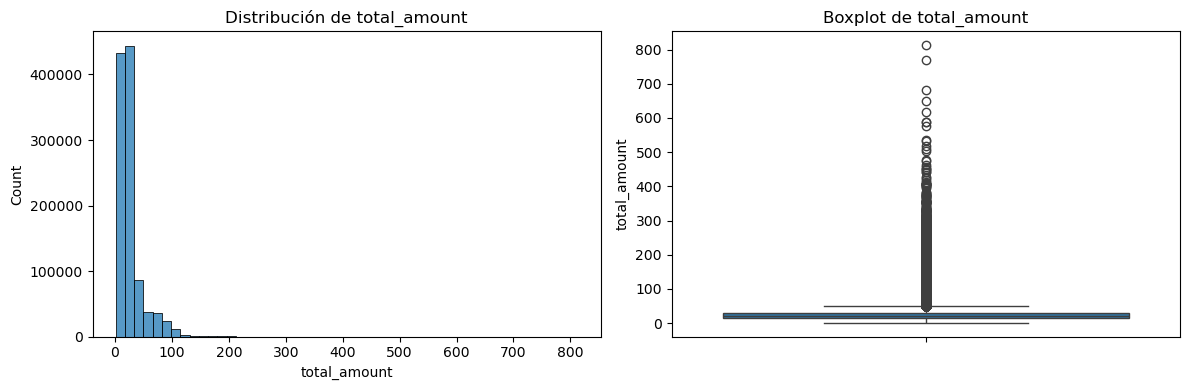

Estadísticas del target:
count     1077989
unique      12138
top         16.80
freq        13391
Name: total_amount, dtype: object


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_pd['total_amount'], bins=50)
plt.title('Distribución de total_amount')
plt.subplot(1, 2, 2)
sns.boxplot(y=df_pd['total_amount'])
plt.title('Boxplot de total_amount')
plt.tight_layout()
plt.show()

print(f"Estadísticas del target:")
print(df_pd['total_amount'].describe())

In [28]:
numeric_features = [
    'passenger_count', 'trip_distance', 'pickup_hour', 
    'pickup_dow', 'month', 'year'
]

categorical_features = [
    'pu_location_id', 'service_type', 'vendor_id', 
    'rate_code_id', 'payment_type'
]

target = 'total_amount'

features = numeric_features + categorical_features
df_ml = df_pd[features + [target]].copy()

In [29]:
df_ml = df_ml.dropna()
print(f"Dataset después de limpieza: {df_ml.shape}")

df_ml['pu_location_id'] = df_ml['pu_location_id'].astype(int)
df_ml['pu_location_id'] = df_ml['pu_location_id'].apply(
    lambda x: x if x <= 265 else 266
)

Dataset después de limpieza: (1077989, 12)


In [30]:
train_data = df_ml[df_ml['year'] <= 2022].copy()
val_data = df_ml[df_ml['year'] == 2023].copy()
test_data = df_ml[df_ml['year'] == 2024].copy()

print(f"Train: {train_data.shape}")
print(f"Val: {val_data.shape}")
print(f"Test: {test_data.shape}")

Train: (368347, 12)
Val: (355604, 12)
Test: (354038, 12)


In [31]:
X_train = train_data[features]
y_train = train_data[target]

X_val = val_data[features]
y_val = val_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', max_categories=50))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_val)

rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)
r2_baseline = r2_score(y_val, y_pred_baseline)

print("Baseline (Regresion Lineal)")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"MAE: {mae_baseline:.4f}")
print(f"R cuadrado: {r2_baseline:.4f}")

Baseline (Regresion Lineal)
RMSE: 11.3626
MAE: 7.6221
R cuadrado: 0.7480


In [34]:
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

tree_reg = DecisionTreeRegressor(
    max_depth=4,
    min_samples_split=150,
    min_samples_leaf=80,
    random_state=RANDOM_STATE
)

ridge_reg = Ridge(
    alpha=1.0,solver="sag",random_state=RANDOM_STATE
)

lasso_reg = Lasso(
    alpha=0.01,
    random_state=RANDOM_STATE,
    max_iter=50
)

voting_reg = VotingRegressor([
    ('tree', tree_reg),
    ('ridge', ridge_reg),
    ('lasso', lasso_reg)
], n_jobs=-1)

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('voting', voting_reg)
])

voting_pipeline.fit(X_train, y_train)
y_pred_voting = voting_pipeline.predict(X_val)

In [35]:
bagging_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
    n_estimators=50,
    bootstrap=True,  # Bagging
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pasting_reg = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=8, random_state=RANDOM_STATE),
    n_estimators=50,
    bootstrap=False,  # Pasting
    random_state=RANDOM_STATE,
    n_jobs=-1
)

bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('bagging', bagging_reg)
])

pasting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pasting', pasting_reg)
])

bagging_pipeline.fit(X_train, y_train)
pasting_pipeline.fit(X_train, y_train)

y_pred_bagging = bagging_pipeline.predict(X_val)
y_pred_pasting = pasting_pipeline.predict(X_val)

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import time

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Pipeline para Gradient Boosting
gbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gbr', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# Parámetros para Grid Search
gbr_params = {
    'gbr__n_estimators': [50, 100],
    'gbr__learning_rate': [0.05, 0.1],
    'gbr__max_depth': [3, 4],
    'gbr__min_samples_split': [2],
    'gbr__subsample': [0.8]
}

# Grid Search con TimeSeriesSplit
print("Iniciando Grid Search para Gradient Boosting")
start_time = time.time()

gbr_grid = GridSearchCV(
    gbr_pipeline,
    gbr_params,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gbr_grid.fit(X_train, y_train)
gbr_time = time.time() - start_time

print(f"Grid Search completado en {gbr_time:.2f} segundos")
print("Mejores parámetros Gradient Boosting:", gbr_grid.best_params_)

# Mejor modelo
best_gbr = gbr_grid.best_estimator_
y_pred_gbr = best_gbr.predict(X_val)

Iniciando Grid Search para Gradient Boosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search completado en 270.42 segundos
Mejores parámetros Gradient Boosting: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 4, 'gbr__min_samples_split': 2, 'gbr__n_estimators': 100, 'gbr__subsample': 0.8}


In [37]:
from lightgbm import LGBMRegressor

# Pipeline para LightGBM
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

# Parámetros para Grid Search
lgbm_params = {
    'lgbm__n_estimators': [50, 100],         
    'lgbm__learning_rate': [0.05, 0.1],            
    'lgbm__num_leaves': [31, 50],             
    'lgbm__max_depth': [-1],                
    'lgbm__min_child_samples': [20],          
    'lgbm__subsample': [0.8],              
    'lgbm__colsample_bytree': [0.8]        
}

print("Iniciando Grid Search para LightGBM")
start_time = time.time()

lgbm_grid = GridSearchCV(
    lgbm_pipeline,
    lgbm_params,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

lgbm_grid.fit(X_train, y_train)
lgbm_time = time.time() - start_time

print(f"Grid Search completado en {lgbm_time:.2f} segundos")
print("Mejores parámetros LightGBM:", lgbm_grid.best_params_)

# Mejor modelo
best_lgbm = lgbm_grid.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_val)

Iniciando Grid Search para LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search completado en 57.96 segundos
Mejores parámetros LightGBM: {'lgbm__colsample_bytree': 0.8, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__min_child_samples': 20, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 50, 'lgbm__subsample': 0.8}


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, y_true, y_pred, fit_time=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    result = {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R cuadrado': r2
    }
    
    if fit_time:
        result['Fit Time (s)'] = fit_time
    
    return result

# Evaluamos todos los modelos
results_val = []

results_val.append(evaluate_model('Baseline (Linear)', y_val, y_pred_baseline))
results_val.append(evaluate_model('Voting', y_val, y_pred_voting))
results_val.append(evaluate_model('Bagging', y_val, y_pred_bagging))
results_val.append(evaluate_model('Pasting', y_val, y_pred_pasting))
results_val.append(evaluate_model('Gradient Boosting', y_val, y_pred_gbr, gbr_time))
results_val.append(evaluate_model('LightGBM', y_val, y_pred_lgbm, lgbm_time))

results_df_val = pd.DataFrame(results_val)
print("\nResultados en Validacion (2023)")
print(results_df_val.round(4))


Resultados en Validacion (2023)
               Model     RMSE     MAE  R cuadrado  Fit Time (s)
0  Baseline (Linear)  11.3626  7.6221      0.7480           NaN
1             Voting  11.4287  7.6182      0.7450           NaN
2            Bagging  11.0539  7.5925      0.7615           NaN
3            Pasting  11.2198  7.6125      0.7543           NaN
4  Gradient Boosting  10.9690  7.6040      0.7651      270.4184
5           LightGBM  11.0295  7.5807      0.7625       57.9608


In [39]:
best_model_name = results_df_val.loc[results_df_val['RMSE'].idxmin(), 'Model']
print(f"Mejor modelo en validación: {best_model_name}")

if best_model_name == 'Gradient Boosting':
    best_model = best_gbr
elif best_model_name == 'LightGBM':
    best_model = best_lgbm
elif best_model_name == 'Voting':
    best_model = voting_pipeline
elif best_model_name == 'Bagging':
    best_model = bagging_pipeline
elif best_model_name == 'Pasting':
    best_model = pasting_pipeline
else:
    best_model = baseline_model

Mejor modelo en validación: Gradient Boosting


In [40]:
print(f"Evaluación final en Test 2024")
y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"RMSE Test: {rmse_test:.4f}")
print(f"MAE Test: {mae_test:.4f}")
print(f"R cuadrado Test: {r2_test:.4f}")

Evaluación final en Test 2024
RMSE Test: 11.3523
MAE Test: 7.8869
R cuadrado Test: 0.7510


## Conclusiones

Tras completar este proyecto de machine learning para predecir tarifas de taxi en Nueva York, hemos obtenido valiosas conclusiones que resumimos en diez puntos clave. 

Primero, logramos un nivel predictivo satisfactorio con un R cuadrado de 0.7510 dado por Gradient Boosting en Testing, demostrando que es posible predecir con considerable precisión el costo de los viajes utilizando variables operativas y temporales. 

Segundo, los métodos de ensemble demostraron superioridad clara sobre modelos simples, con Gradient Boosting emergiendo como el mejor performer en términos de precisión. 

Tercero, descubrimos que LightGBM ofrece una alternativa extremadamente eficiente, siendo 4.6 veces más rápido que Gradient Boosting con un rendimiento muy similar, lo que lo hace ideal para entornos que requieren iteraciones rápidas. 

Cuarto, la validación temporal por años demostró ser crucial para evaluar la verdadera capacidad de generalización de los modelos hacia datos futuros. 

Quinto, la ingeniería de características temporales como hora del día, día de la semana y mes resultaron ser predictores fundamentales en el modelo. 

Sexto, el preprocesamiento mediante pipelines estandarizados mostró ser esencial para mantener la consistencia entre entrenamiento y validación. 

Séptimo, el método de Bagging superó a Pasting, confirmando la utilidad del muestreo con reemplazo en nuestro conjunto de datos. 

Octavo, establecimos que existe un trade-off claro entre precisión y velocidad computacional que debe considerarse según los requisitos del proyecto. 

Noveno, el proyecto demostró la escalabilidad de estos métodos para manejar volúmenes de datos considerables superando el millón de registros. 

Décimo, como aprendizaje global, confirmamos que los ensemble methods deben ser el approach principal después de establecer un baseline simple, representando el mejor balance entre complejidad y rendimiento para problemas de regresión con datos del mundo real.
primer approach: Deberían ser la primera opción después del baseline